In [1]:
# Importing pandas and sqlite3
import pandas as pd
import sqlite3
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

In [2]:
# Querying SQL to return the sum of Home Wins and Home Losses corresponding to the Home Team
# for German leagues and the 2011 season.
# We can ignore the goal summary.
cur.execute("""SELECT distinct HomeTeam,   
                CASE
                WHEN FTR = 'A' THEN SUM(FTAG)
                WHEN FTR = 'H' THEN SUM(FTHG)
                WHEN FTR = 'D' THEN SUM(FTAG)
                ELSE 0 END AS "Total goals"
                ,SUM(CASE WHEN FTR = 'H' then 1 else 0 end) "Home_Wins"
                ,SUM(CASE WHEN FTR = 'A' then 1 ELSE 0 END) "Home_Losses"
                FROM matches
                WHERE season = 2011 and Div != 'E0'
                GROUP BY 1 
                ORDER BY 1
                ;""")
home_wins_loss = pd.DataFrame(cur.fetchall())
home_wins_loss.columns = [x[0] for x in cur.description]
home_wins_loss.head()

,HomeTeam,Total goals,Home_Wins,Home_Losses
0,Aachen,24,4,7
1,Augsburg,19,6,4
2,Bayern Munich,6,14,2
3,Bochum,23,7,7
4,Braunschweig,15,6,3


In [3]:
# Querying SQL to return the sum of Away Wins and Away Losses corresponding to the Away Team
# for German leagues and the 2011 season.
# We can ignore the goal summary.
cur.execute("""SELECT distinct AwayTeam,   
                CASE
                WHEN FTR = 'A' THEN SUM(FTAG)
                WHEN FTR = 'H' THEN SUM(FTHG)
                WHEN FTR = 'D' THEN SUM(FTAG)
                ELSE 0 END AS "Total goals"
                ,SUM(CASE WHEN FTR = 'A' then 1 else 0 end) "Away_Wins"
                ,SUM(CASE WHEN FTR = 'H' then 1 ELSE 0 END) "Away_Losses"
                FROM matches
                WHERE season = 2011 and Div != 'E0'
                GROUP BY 1 
                ORDER BY 1
                ;""")
away_wins_loss = pd.DataFrame(cur.fetchall())
away_wins_loss.columns = [x[0] for x in cur.description]
away_wins_loss.head()

,AwayTeam,Total goals,Away_Wins,Away_Losses
0,Aachen,23,2,8
1,Augsburg,30,2,8
2,Bayern Munich,28,9,5
3,Bochum,32,3,10
4,Braunschweig,20,4,6


In [4]:
# Joining the two tables together and dropping unnecessary columns.
total_wins_loss_df = pd.concat([home_wins_loss, away_wins_loss], axis = 1)
total_wins_loss_df.drop(['AwayTeam'], axis =1, inplace=True)
total_wins_loss_df.head()

,HomeTeam,Total goals,Home_Wins,Home_Losses,Total goals,Away_Wins,Away_Losses
0,Aachen,24,4,7,23,2,8
1,Augsburg,19,6,4,30,2,8
2,Bayern Munich,6,14,2,28,9,5
3,Bochum,23,7,7,32,3,10
4,Braunschweig,15,6,3,20,4,6


In [5]:
# Totaling the wins and losses in new columns
total_wins_loss_df['Total_Wins'] = total_wins_loss_df['Away_Wins'] + total_wins_loss_df['Home_Wins']
total_wins_loss_df['Total_Losses'] = total_wins_loss_df['Home_Losses'] + total_wins_loss_df['Away_Losses']
total_wins_loss_df.head()

,HomeTeam,Total goals,Home_Wins,Home_Losses,Total goals,Away_Wins,Away_Losses,Total_Wins,Total_Losses
0,Aachen,24,4,7,23,2,8,6,15
1,Augsburg,19,6,4,30,2,8,8,12
2,Bayern Munich,6,14,2,28,9,5,23,7
3,Bochum,23,7,7,32,3,10,10,17
4,Braunschweig,15,6,3,20,4,6,10,9


In [6]:
# Creating a new df containing only the wins and losses.
team_win_loss = total_wins_loss_df[['Total_Wins', 'Total_Losses']]
team_win_loss.head()

,Total_Wins,Total_Losses
0,6,15
1,8,12
2,23,7
3,10,17
4,10,9


In [7]:
# Finding the correct value for total goals for each team when they played at home.
cur.execute("""SELECT HomeTeam, SUM(FTHG) as Total_Home_Goals
                FROM Matches
                WHERE Season = 2011 and Div != 'E0'
                GROUP BY HomeTeam
                 ;""")
team_goals_home_df = pd.DataFrame(cur.fetchall())
team_goals_home_df.columns = [x[0] for x in cur.description]
team_goals_home_df.head()

,HomeTeam,Total_Home_Goals
0,Aachen,15
1,Augsburg,20
2,Bayern Munich,49
3,Bochum,23
4,Braunschweig,21


In [8]:
# Finding the correct value for total goals for each team when then played away.
cur.execute("""SELECT AwayTeam, SUM(FTAG) as Total_Away_Goals
                FROM Matches
                WHERE Season = 2011 and Div != 'E0'
                GROUP BY AwayTeam
                 ;""")
team_goals_away_df = pd.DataFrame(cur.fetchall())
team_goals_away_df.columns = [x[0] for x in cur.description]
team_goals_away_df.head()

,AwayTeam,Total_Away_Goals
0,Aachen,15
1,Augsburg,16
2,Bayern Munich,28
3,Bochum,18
4,Braunschweig,16


In [9]:
# Combining total goals scored in a single dataframe.
Home_Away_Goals = pd.concat([team_goals_away_df, team_goals_home_df], axis = 1)
Home_Away_Goals.drop(['HomeTeam'], axis = 1, inplace =True)
Home_Away_Goals.rename(columns = {'AwayTeam': 'Team_Name'}, inplace = True)
Home_Away_Goals.head()

,Team_Name,Total_Away_Goals,Total_Home_Goals
0,Aachen,15,15
1,Augsburg,16,20
2,Bayern Munich,28,49
3,Bochum,18,23
4,Braunschweig,16,21


In [10]:
# Totaling the goals to achieve a grand total in a new column.
Home_Away_Goals['Total_Goals'] = Home_Away_Goals['Total_Away_Goals'] + Home_Away_Goals['Total_Home_Goals']
Home_Away_Goals.head()

,Team_Name,Total_Away_Goals,Total_Home_Goals,Total_Goals
0,Aachen,15,15,30
1,Augsburg,16,20,36
2,Bayern Munich,28,49,77
3,Bochum,18,23,41
4,Braunschweig,16,21,37


In [11]:
# Isolating the name and total goals into a new df ready to be merged with the wins table.
goals_df = Home_Away_Goals[['Team_Name', 'Total_Goals']]
goals_df.head()

,Team_Name,Total_Goals
0,Aachen,30
1,Augsburg,36
2,Bayern Munich,77
3,Bochum,41
4,Braunschweig,37


In [12]:
# Combining all information. 
# Here we have each team followed by their total goals, total wins and total losses.
win_loss_goal_df = pd.concat([goals_df, team_win_loss], axis = 1)
win_loss_goal_df.head()

,Team_Name,Total_Goals,Total_Wins,Total_Losses
0,Aachen,30,6,15
1,Augsburg,36,8,12
2,Bayern Munich,77,23,7
3,Bochum,41,10,17
4,Braunschweig,37,10,9


Visualisation of German Teams Wins and Losses for 2011

In [13]:
# Importing relevant libraries for visualition.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Teams')

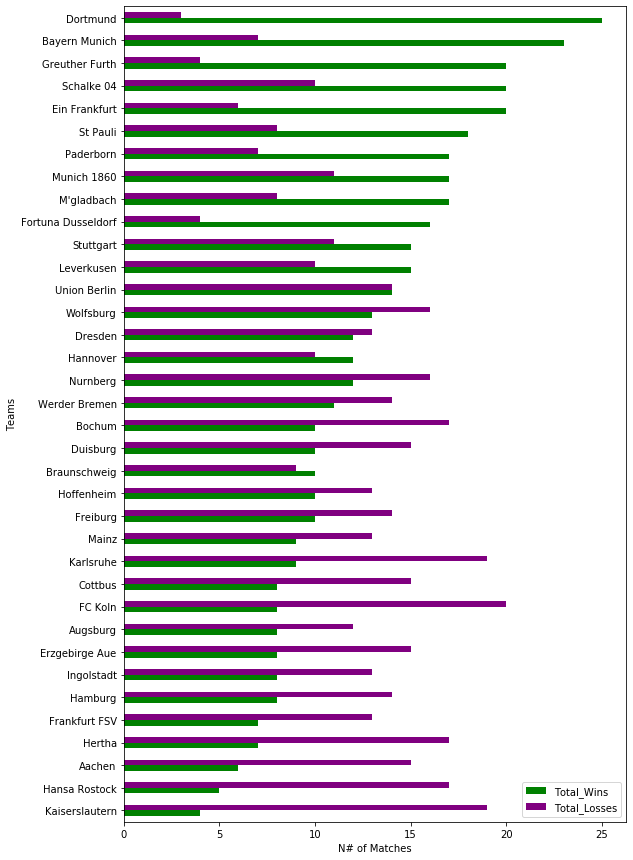

In [14]:
# Sorting the data by total wins, ascending and creating a histogram to represent the data.
sorted_wins = win_loss_goal_df.sort_values(['Total_Wins'], ascending = True)
sorted_wins.plot.barh(x = 'Team_Name', y = ['Total_Wins', 'Total_Losses'], color = ['green', 'purple'],
                        figsize = (9,15))
plt.xlabel('N# of Matches')
plt.ylabel('Teams')

Using the Dark Sky API to find matches played in the rain in the German Leagues

In [15]:
%reload_ext autoreload
%autoreload 2
import lib
import requests
from lib import MongoHandler, WeatherGetter
import json
import pandas as pd
import numpy as np
import sqlite3
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

In [133]:
get_weather = WeatherGetter()

In [17]:
dates = cur.execute("""SELECT DISTINCT(Date) 
                        FROM Matches
                        WHERE Season like "%2011%"
                        ;""").fetchall()

In [18]:
# The dates list would not work when being passed through the URL.
# Formatting dates along with the time would like the weather API to use.
dates_list = []
for clean_dates in dates:  
    for item in clean_dates:  
        dates_list.append(item + 'T15:00:00')

In [19]:
dates_list
# This is the proper format for the API as listed in DarkSky documentation.

['2012-03-31T15:00:00',
 '2011-12-11T15:00:00',
 '2011-08-13T15:00:00',
 '2011-11-27T15:00:00',
 '2012-02-18T15:00:00',
 '2012-01-20T15:00:00',
 '2012-02-04T15:00:00',
 '2012-04-21T15:00:00',
 '2011-09-18T15:00:00',
 '2011-10-23T15:00:00',
 '2011-10-01T15:00:00',
 '2012-03-03T15:00:00',
 '2011-08-27T15:00:00',
 '2012-03-17T15:00:00',
 '2011-11-06T15:00:00',
 '2012-05-05T15:00:00',
 '2012-04-11T15:00:00',
 '2011-12-17T15:00:00',
 '2012-02-03T15:00:00',
 '2011-10-29T15:00:00',
 '2012-01-22T15:00:00',
 '2011-12-03T15:00:00',
 '2012-04-14T15:00:00',
 '2012-03-25T15:00:00',
 '2012-03-10T15:00:00',
 '2012-04-07T15:00:00',
 '2011-11-19T15:00:00',
 '2011-10-14T15:00:00',
 '2011-09-24T15:00:00',
 '2012-04-28T15:00:00',
 '2011-12-18T15:00:00',
 '2012-03-02T15:00:00',
 '2012-03-16T15:00:00',
 '2012-02-17T15:00:00',
 '2011-08-06T15:00:00',
 '2011-11-04T15:00:00',
 '2011-09-16T15:00:00',
 '2011-07-15T15:00:00',
 '2012-05-06T15:00:00',
 '2012-02-11T15:00:00',
 '2011-10-02T15:00:00',
 '2012-03-30T15:

In [57]:
# Getting the weather for all match dates in 2011 at 3pm.
# Taken Berlin coordinates as the default. 
weather_dicts = {}

get_weather = WeatherGetter()

for date in dates_list:
    call = get_weather.weather_getter(date)
    result = call.json()
    weather_dicts[date] = result['currently'].get('icon') if result['currently'].get('icon') else result['currently'].get('summary')

In [58]:
weather_dicts

{'2012-03-31T15:00:00': 'partly-cloudy-day',
 '2011-12-11T15:00:00': 'partly-cloudy-day',
 '2011-08-13T15:00:00': 'partly-cloudy-day',
 '2011-11-27T15:00:00': 'partly-cloudy-day',
 '2012-02-18T15:00:00': 'partly-cloudy-day',
 '2012-01-20T15:00:00': 'partly-cloudy-day',
 '2012-02-04T15:00:00': 'clear-day',
 '2012-04-21T15:00:00': 'partly-cloudy-day',
 '2011-09-18T15:00:00': 'partly-cloudy-day',
 '2011-10-23T15:00:00': None,
 '2011-10-01T15:00:00': None,
 '2012-03-03T15:00:00': None,
 '2011-08-27T15:00:00': 'partly-cloudy-day',
 '2012-03-17T15:00:00': None,
 '2011-11-06T15:00:00': None,
 '2012-05-05T15:00:00': 'partly-cloudy-day',
 '2012-04-11T15:00:00': 'partly-cloudy-day',
 '2011-12-17T15:00:00': 'partly-cloudy-day',
 '2012-02-03T15:00:00': 'partly-cloudy-day',
 '2011-10-29T15:00:00': None,
 '2012-01-22T15:00:00': 'partly-cloudy-day',
 '2011-12-03T15:00:00': 'partly-cloudy-day',
 '2012-04-14T15:00:00': 'partly-cloudy-day',
 '2012-03-25T15:00:00': None,
 '2012-03-10T15:00:00': 'partly-c

In [59]:
new_weather_dict = {}
for i in weather_dicts:
    new_weather_dict[i[:10]] = weather_dicts[i]

In [60]:
new_weather_dict

{'2012-03-31': 'partly-cloudy-day',
 '2011-12-11': 'partly-cloudy-day',
 '2011-08-13': 'partly-cloudy-day',
 '2011-11-27': 'partly-cloudy-day',
 '2012-02-18': 'partly-cloudy-day',
 '2012-01-20': 'partly-cloudy-day',
 '2012-02-04': 'clear-day',
 '2012-04-21': 'partly-cloudy-day',
 '2011-09-18': 'partly-cloudy-day',
 '2011-10-23': None,
 '2011-10-01': None,
 '2012-03-03': None,
 '2011-08-27': 'partly-cloudy-day',
 '2012-03-17': None,
 '2011-11-06': None,
 '2012-05-05': 'partly-cloudy-day',
 '2012-04-11': 'partly-cloudy-day',
 '2011-12-17': 'partly-cloudy-day',
 '2012-02-03': 'partly-cloudy-day',
 '2011-10-29': None,
 '2012-01-22': 'partly-cloudy-day',
 '2011-12-03': 'partly-cloudy-day',
 '2012-04-14': 'partly-cloudy-day',
 '2012-03-25': None,
 '2012-03-10': 'partly-cloudy-day',
 '2012-04-07': 'partly-cloudy-day',
 '2011-11-19': None,
 '2011-10-14': 'partly-cloudy-day',
 '2011-09-24': 'clear-day',
 '2012-04-28': None,
 '2011-12-18': 'partly-cloudy-day',
 '2012-03-02': 'partly-cloudy-day',

In [86]:
weather_date_df = pd.DataFrame.from_dict(new_weather_dict, orient = 'index')
weather_date_df.rename(columns = {0 : 'Weather'}, inplace = True)
weather_date_df.info

<bound method DataFrame.info of                       Weather
2012-03-31  partly-cloudy-day
2011-12-11  partly-cloudy-day
2011-08-13  partly-cloudy-day
2011-11-27  partly-cloudy-day
2012-02-18  partly-cloudy-day
2012-01-20  partly-cloudy-day
2012-02-04          clear-day
2012-04-21  partly-cloudy-day
2011-09-18  partly-cloudy-day
2011-10-23               None
2011-10-01               None
2012-03-03               None
2011-08-27  partly-cloudy-day
2012-03-17               None
2011-11-06               None
2012-05-05  partly-cloudy-day
2012-04-11  partly-cloudy-day
2011-12-17  partly-cloudy-day
2012-02-03  partly-cloudy-day
2011-10-29               None
2012-01-22  partly-cloudy-day
2011-12-03  partly-cloudy-day
2012-04-14  partly-cloudy-day
2012-03-25               None
2012-03-10  partly-cloudy-day
2012-04-07  partly-cloudy-day
2011-11-19               None
2011-10-14  partly-cloudy-day
2011-09-24          clear-day
2012-04-28               None
...                       ...
2011-08-

In [62]:
# Creating a dataframe containing the date and weather. 
weather_date_df.reset_index(inplace = True)
weather_date_df.head()

,index,Weather
0,2012-03-31,partly-cloudy-day
1,2011-12-11,partly-cloudy-day
2,2011-08-13,partly-cloudy-day
3,2011-11-27,partly-cloudy-day
4,2012-02-18,partly-cloudy-day


In [63]:
# Isolating the match days where it was raining. 
rain_dates = weather_date_df.loc[weather_date_df['Weather'] == 'rain']
rain_dates

,index,Weather
106,2011-08-08,rain
120,2011-07-22,rain
143,2012-01-01,rain
144,2012-01-02,rain
150,2012-01-16,rain


In [64]:
# only five days of rain in our season. 
weather_date_df.groupby('Weather').count()

,index
Weather,
clear-day,13
cloudy,1
partly-cloudy-day,102
rain,5


In [65]:
rains_df = rain_dates.rename(columns={'index': 'Date'})

In [70]:
rains_df

,Date,Weather
106,2011-08-08,rain
120,2011-07-22,rain
143,2012-01-01,rain
144,2012-01-02,rain
150,2012-01-16,rain


In [66]:
rain_dates.to_csv('Rain_Dates.csv')

In [67]:
# Selecting dates and teams from 2011 and in the german leagues. 
cur.execute("""SELECT Date, HomeTeam, AwayTeam, FTR 
                FROM matches
                WHERE Season = '2011' and Div != 'E0'
                ;""")
german_match_days = pd.DataFrame(cur.fetchall())
german_match_days.columns = [x[0] for x in cur.description]
german_match_days.head()

,Date,HomeTeam,AwayTeam,FTR
0,2012-03-31,Nurnberg,Bayern Munich,A
1,2011-12-11,Stuttgart,Bayern Munich,A
2,2011-08-13,Wolfsburg,Bayern Munich,A
3,2011-11-27,Mainz,Bayern Munich,H
4,2012-02-18,Freiburg,Bayern Munich,D


In [73]:
# Combining the german match days with days that it rained.
rain_matches_df = pd.merge(left = rains_df, right = german_match_days, left_on = 'Date', right_on = 'Date')
rain_matches_df

,Date,Weather,HomeTeam,AwayTeam,FTR
0,2011-08-08,rain,Hansa Rostock,Bochum,D
1,2011-07-22,rain,Duisburg,Cottbus,A
2,2011-07-22,rain,Ingolstadt,Erzgebirge Aue,D
3,2011-07-22,rain,Bochum,Frankfurt FSV,H


In [74]:
import pandas as pd 
import sqlite3
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()
pysqldf = lambda q: sqldf(q, globals())

In [75]:
# Number of home wins
Home_Wins = []
Win = 1
Draw_Loss = 0
for result in list(rain_matches_df.FTR):
    if result == 'H':
        Home_Wins.append(Win) 
    elif result == 'D' or 'A':
        Home_Wins.append(Draw_Loss)
len(Home_Wins)

4

In [76]:
# Number of away wins
Away_Wins = []
Win = 1
Draw_Loss = 0
for result in list(rain_matches_df.FTR):
    if result == 'H':
        Away_Wins.append(Win) 
    elif result == 'D' or 'A':
        Away_Wins.append(Draw_Loss)
len(Away_Wins)

4

In [134]:

Home_Wins_2011 = pd.Series(Home_Wins)
Away_Wins_2011 = pd.Series(Away_Wins)
rain_matches_df.insert(loc= 5, column = 'HomeWins 2011', value = Home_Wins_2011 )
rain_matches_df.insert(loc= 6, column = 'AwayWins 2011', value = Away_Wins_2011 )
rain_matches_df

ValueError: cannot insert HomeWins 2011, already exists

In [81]:
home_rain = rain_matches_df.groupby(by='HomeTeam')['HomeWins 2011'].agg(['sum','count'])
away_rain = rain_matches_df.groupby(by ='AwayTeam')['AwayWins 2011'].agg(['sum', 'count'])

In [82]:
# Peforming an outer join here would include all the datapoints
rain_stats_merged = home_rain.join(away_rain, how = 'outer', lsuffix = '_home', rsuffix = '_away')
rain_stats_merged.fillna(value = 0, inplace=True) # Lots of null values, we can change these to 0
# So count is our games played, and sum is our wins
rain_stats_merged['TotalRainMatches_2011'] = rain_stats_merged['count_home'] + rain_stats_merged['count_away']
rain_stats_merged['TotalRainWins_2011'] = rain_stats_merged['sum_home'] + rain_stats_merged['sum_away']
rain_stats_merged['RainWinPercentage_2011'] = round(rain_stats_merged['TotalRainWins_2011']/ rain_stats_merged['TotalRainMatches_2011'], 2)
rain_stats_merged.head()

,sum_home,count_home,sum_away,count_away,TotalRainMatches_2011,TotalRainWins_2011,RainWinPercentage_2011
Bochum,1.0,1.0,0.0,1.0,2.0,1.0,0.5
Cottbus,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Duisburg,0.0,1.0,0.0,0.0,1.0,0.0,0.0
Erzgebirge Aue,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Frankfurt FSV,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [83]:
rain_stats_merged.reset_index(inplace = True)
rain_stats_merged.rename(columns={'index': 'TeamName'}, inplace = True)
rain_stats_merged.drop(['sum_home', 'count_home', 'sum_away', 'count_away'], axis = 1, inplace = True)

In [84]:
rain_stats_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
TeamName                  7 non-null object
TotalRainMatches_2011     7 non-null float64
TotalRainWins_2011        7 non-null float64
RainWinPercentage_2011    7 non-null float64
dtypes: float64(3), object(1)
memory usage: 304.0+ bytes


In [87]:
# Found Rain Win %
rain_stats_merged

,TeamName,TotalRainMatches_2011,TotalRainWins_2011,RainWinPercentage_2011
0,Bochum,2.0,1.0,0.5
1,Cottbus,1.0,0.0,0.0
2,Duisburg,1.0,0.0,0.0
3,Erzgebirge Aue,1.0,0.0,0.0
4,Frankfurt FSV,1.0,1.0,1.0
5,Hansa Rostock,1.0,0.0,0.0
6,Ingolstadt,1.0,0.0,0.0


# Transposing Database Using MongoDB

In [88]:
Transposed = rain_stats_merged.transpose()
Transposed.to_json('Data_for_MongoDB.json')

In [124]:
import pymongo

In [129]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['Delphi_Football']
german_league = mydb['German_Team_Stats']

In [130]:
myclient.list_database_names()

['admin', 'config', 'local']

In [97]:
big_df = pd.concat([rain_stats_merged, win_loss_goal_df], axis = 1)


In [118]:
rain_stats_merged
rain_stats_merged.rename(columns={"TeamName": "Team_Name"}, inplace=True)

In [119]:
win_loss_goal_df.head()

,Team_Name,Total_Goals,Total_Wins,Total_Losses
0,Aachen,30,6,15
1,Augsburg,36,8,12
2,Bayern Munich,77,23,7
3,Bochum,41,10,17
4,Braunschweig,37,10,9


In [121]:
df_inner = pd.merge(win_loss_goal_df, rain_stats_merged, on='Team_Name', how='inner')
df_inner

,Team_Name,Total_Goals,Total_Wins,Total_Losses,TotalRainMatches_2011,TotalRainWins_2011,RainWinPercentage_2011
0,Bochum,41,10,17,2.0,1.0,0.5
1,Cottbus,30,8,15,1.0,0.0,0.0
2,Duisburg,42,10,15,1.0,0.0,0.0
3,Erzgebirge Aue,31,8,15,1.0,0.0,0.0
4,Frankfurt FSV,43,7,13,1.0,1.0,1.0
5,Hansa Rostock,34,5,17,1.0,0.0,0.0
6,Ingolstadt,43,8,13,1.0,0.0,0.0


In [132]:
df_inner_json = df_inner.T.to_json()
df_json_list = json.loads(df_inner_json).values()
german_league.insert_many(df_json_list)